# Projet 6 - Tests

L'objectif est d'employer (et comparer) des approches supervisées et non-supervisées.
Nous allons également faire varier les paramètres spécifiques de chaque approche afin d'étudier leur influence:
* taille des entrées (nombre de mots du vocabulaire)
* paramètres des algorithmes(nombre de topics dans LDA, seuils pour attribuer un tag, etc..)
* méthodes linéaires et non-linéaires

# 1.Initialisation

In [8]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# Import the `pandas` library as `pd`
import pandas as pd
# Import pyplot from matplotlib as plt
import matplotlib.pyplot as plt
# Import the `numpy` library as `np`
import numpy as np

import os
import re


from joblib import dump, load

In [0]:
from time import time

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import jaccard_score, make_scorer, classification_report
from sklearn.model_selection  import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
# from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import LatentDirichletAllocation

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# cache directory for joblib objects
folder = "/content/gdrive/My Drive/Colab Notebooks/P6 - Categ questions/joblib_memmap"
try:
    os.mkdir(folder)
except FileExistsError:
    pass

In [0]:
data_filename_memmap = os.path.join(folder, 'X_train_memmap')
X_train = load(data_filename_memmap, mmap_mode='r')
data_filename_memmap = os.path.join(folder, 'y_train_memmap')
y_train = load(data_filename_memmap, mmap_mode='r')
data_filename_memmap = os.path.join(folder, 'X_test_memmap')
X_test = load(data_filename_memmap, mmap_mode='r')
data_filename_memmap = os.path.join(folder, 'y_test_memmap')
y_test = load(data_filename_memmap, mmap_mode='r')

In [0]:
data_filename_memmap = os.path.join(folder, 'X_train_count_memmap')
X_train_count = load(data_filename_memmap, mmap_mode='r')
data_filename_memmap = os.path.join(folder, 'X_test_count_memmap')
X_test_count = load(data_filename_memmap, mmap_mode='r')
data_filename_memmap = os.path.join(folder, 'data_memmap')
data = load(data_filename_memmap, mmap_mode='r')

In [0]:
data_filename_memmap = os.path.join(folder, 'vector_memmap')
vectorizer = load(data_filename_memmap, mmap_mode='r')
data_filename_memmap = os.path.join(folder, 'vocab_memmap')
terms_list = load(data_filename_memmap, mmap_mode='r')

In [0]:
data_filename_memmap = os.path.join(folder, 'dist_terms_memmap')
dist_terms = load(data_filename_memmap, mmap_mode='r')

In [0]:
data_filename_memmap = os.path.join(folder, 'doc_len_memmap')
doc_len = load(data_filename_memmap, mmap_mode='r')

# 2. Term frequency

In [0]:
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_count)
X_train_tf = tf_transformer.transform(X_train_count)
X_test_tf = tf_transformer.transform(X_test_count)

In [0]:
tfidf_transformer = TfidfTransformer(use_idf=True).fit(X_train_count)
X_train_tfidf = tfidf_transformer.transform(X_train_count)
X_test_tfidf = tfidf_transformer.transform(X_test_count)

In [0]:
X_train_tf.shape

(13957, 1000)

In [0]:
X_train_tfidf.shape

(13957, 1000)

# 3.Approche supervisée

On utilise un classifier multilabel

In [0]:
# X_train_tf.toarray()

## 3.1. SVC

### a.TF

In [0]:
SVC_tf = OneVsRestClassifier(SVC(random_state=0))

# SVC_tf = OneVsRestClassifier(SVC(random_state=0, decision_function_shape='ovo'))

In [0]:
SVC_param = {"estimator__C": [0.1, 1],
             "estimator__max_iter": [-1],
             "estimator__kernel": ['linear'],
             "estimator__gamma": ['auto']
            }
# SVC_param = {
# #     "estimator__C": [0.01,0.1,0.2],
#     "estimator__C": [0.1, 0.2, 1],
#     "estimator__max_iter": [-1],
#     "estimator__kernel": ['linear', 'rbf'],
#     "estimator__gamma": ['auto', 'scale']
#     }

# SVC_param = {
# #     "estimator__C": [0.01,0.1,0.2],
#     "estimator__C": [0.1, 1,100, 1000],
#     "estimator__max_iter": [1000,2000],
#     "estimator__kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
#     "estimator__gamma": ['auto', 'scale'],
#     "estimator__degree":[1, 2, 3],
#     }

In [0]:
gs_svc = GridSearchCV(SVC_tf, param_grid = SVC_param, cv=5,
                      scoring = make_scorer(jaccard_score, average= 'samples'),
                      n_jobs = -1)

# model_tunning = SVC_tf


In [0]:
t0 = time()

In [0]:
gs_svc = gs_svc.fit(X_train_tf, y_train)

In [0]:
t_gs_svc_tf = time() - t0
print("Temps d'exécution: %0.3fs" % (t_gs_svc_tf))

Temps d'exécution: 1467.912s


In [0]:
# print(tf_vectorizer.get_feature_names())

In [0]:
# pred_SVC_tf = OneVsRestClassifier(LinearSVC(random_state=0)).fit(tf, y_train).predict(tf)

In [0]:
# SVC_tf.estimator.get_params().keys()

In [0]:
# start = time.time()

# model_tunning.fit(tf, y_train)

# end = time.time()
# print(end - start)

In [0]:
print(gs_svc.best_score_)
print(gs_svc.best_params_)

0.5496895225812614
{'estimator__C': 1, 'estimator__gamma': 'auto', 'estimator__kernel': 'linear', 'estimator__max_iter': -1}


In [0]:
# SVC_tf = OneVsRestClassifier(LinearSVC(random_state=0)).fit(tf, y_train)

In [0]:
pred_SVC_tf = gs_svc.predict(X_test_tf)

In [0]:
svc_tf_score = jaccard_score(y_test, pred_SVC_tf, average='samples')

In [0]:
# tf_test.toarray().shape

In [0]:
# start = time.time()

# SVC_tf.fit(tf, y_train)

# end = time.time()
# print(end - start)

In [0]:
# prediction = SVC_tf.predict(tf_test)

In [0]:
# prediction.size

In [0]:
# prediction[0].size

In [0]:
pd.DataFrame.from_dict(gs_svc.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_estimator__gamma,param_estimator__kernel,param_estimator__max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,215.053238,0.899916,47.824673,0.519803,0.1,auto,linear,-1,"{'estimator__C': 0.1, 'estimator__gamma': 'aut...",0.320869,0.322624,0.322292,0.324370,0.330891,0.324209,0.003522,2
1,195.347537,1.209243,39.893362,2.274291,1,auto,linear,-1,"{'estimator__C': 1, 'estimator__gamma': 'auto'...",0.539362,0.549690,0.547528,0.556688,0.555183,0.549690,0.006172,1


In [0]:
# On initialise un dictionnaire dans lequel on va stocker les performances pour comparaison
resultats = {'Algorithme': [], 'Term Freq.': [], 'Score': [], 'Temps': []}

In [0]:
# On ajoute le score et temps d'entrainement pour la SVC et TF
resultats['Algorithme'].append('SVC')
resultats['Term Freq.'].append('TF')
resultats['Score'].append(svc_tf_score)
resultats['Temps'].append(t_gs_svc_tf)

In [0]:
print(classification_report(y_test, pred_SVC_tf, target_names=y_test.columns))

                     precision    recall  f1-score   support

               .net       1.00      0.09      0.17        44
          .net-core       0.70      0.41      0.52        46
amazon-web-services       0.89      0.47      0.62        34
            android       0.93      0.78      0.85       411
     android-gradle       0.00      0.00      0.00        32
     android-studio       0.70      0.38      0.49        92
            angular       0.96      0.83      0.89       358
        angular-cli       0.80      0.53      0.64        30
       apache-spark       0.96      0.76      0.85        29
             arrays       0.57      0.24      0.33        51
            asp.net       0.00      0.00      0.00        36
       asp.net-core       0.81      0.67      0.73        72
                  c       0.78      0.43      0.56        67
                 c#       0.82      0.44      0.57       202
                c++       0.94      0.83      0.88       265
              c++11    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [0]:
pred_SVC_tf.sum()

3509

### b.TF-IDF

In [0]:
t0 = time()

In [0]:
gs_svc = gs_svc.fit(X_train_tfidf, y_train)

In [0]:
t_gs_svc_tfidf = time() - t0
print("Temps d'exécution: %0.3fs" % (t_gs_svc_tfidf))

Temps d'exécution: 1424.123s


In [0]:
print(gs_svc.best_score_)
print(gs_svc.best_params_)

0.5601800769028683
{'estimator__C': 1, 'estimator__gamma': 'auto', 'estimator__kernel': 'linear', 'estimator__max_iter': -1}


In [0]:
pred_SVC_tfidf = gs_svc.predict(X_test_tfidf)

In [0]:
svc_tfidf_score = jaccard_score(y_test, pred_SVC_tfidf, average='samples')

In [0]:
# On ajoute le score et temps d'entrainement pour la SVC et TF-IDF
resultats['Algorithme'].append('SVC')
resultats['Term Freq.'].append('TF-IDF')
resultats['Score'].append(svc_tfidf_score)
resultats['Temps'].append(t_gs_svc_tfidf)

In [0]:
print(classification_report(y_test, pred_SVC_tfidf, target_names=y_test.columns))

                     precision    recall  f1-score   support

               .net       1.00      0.11      0.20        44
          .net-core       0.68      0.41      0.51        46
amazon-web-services       0.89      0.50      0.64        34
            android       0.93      0.78      0.85       411
     android-gradle       0.00      0.00      0.00        32
     android-studio       0.70      0.36      0.47        92
            angular       0.95      0.85      0.90       358
        angular-cli       0.80      0.53      0.64        30
       apache-spark       0.96      0.79      0.87        29
             arrays       0.57      0.24      0.33        51
            asp.net       0.00      0.00      0.00        36
       asp.net-core       0.81      0.67      0.73        72
                  c       0.78      0.48      0.59        67
                 c#       0.80      0.48      0.60       202
                c++       0.93      0.83      0.88       265
              c++11    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


## 3.2. Random Forest

### a.TF

In [0]:
RF_model = RandomForestClassifier()
RF_param = { 
    'n_estimators': [10, 100],
    'criterion': ["gini", "entropy"],
    'max_features': ['sqrt', 'log2']
}

# RF_param = {"estimator__n_estimators": [10, 100],
#             "bootstrap": [True, False],
#             "estimator__criterion": ["gini", "entropy"],
#     'max_features': ['auto', 'sqrt', 'log2']
#            }
gs_rf = GridSearchCV(RF_model, param_grid = RF_param, cv=5,
                     scoring = make_scorer(jaccard_score, average= 'samples'),
                     n_jobs = -1)


In [0]:
RF_model = RandomForestClassifier()
gs_rf = GridSearchCV(RF_model, param_grid = RF_param, cv=5,
                     scoring = make_scorer(jaccard_score, average= 'samples'),
                     n_jobs = -1)
gs_rf = gs_rf.fit(X_train_tf, y_train)

In [0]:
RF_model.get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [0]:
t0 = time()

gs_rf = gs_rf.fit(X_train_tf, y_train)

t_gs_rf_tf = time() - t0
print("Temps d'exécution: %0.3fs" % (t_gs_rf_tf))


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Temps d'exécution: 1383.437s


In [0]:
# print(rf_grid.grid_scores_)
print(gs_rf.best_score_)
print(gs_rf.best_params_)

0.530466193785675
{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}


In [0]:
pd.DataFrame.from_dict(gs_rf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,10.429036,0.079201,0.251502,0.008310,gini,sqrt,10,"{'criterion': 'gini', 'max_features': 'sqrt', ...",0.477567,0.492586,0.499200,0.499761,0.485125,0.490847,0.008501,2
1,101.702402,0.960839,2.164373,0.013805,gini,sqrt,100,"{'criterion': 'gini', 'max_features': 'sqrt', ...",0.520386,0.535267,0.534820,0.534074,0.527786,0.530466,0.005724,1
2,5.702072,0.062401,0.249245,0.012660,gini,log2,10,"{'criterion': 'gini', 'max_features': 'log2', ...",0.297785,0.297887,0.320220,0.285973,0.292828,0.298938,0.011495,6
3,56.911480,0.315377,2.184447,0.032864,gini,log2,100,"{'criterion': 'gini', 'max_features': 'log2', ...",0.334318,0.348078,0.351093,0.351863,0.352860,0.347642,0.006851,5
4,18.571878,0.138217,0.242930,0.007353,entropy,sqrt,10,"{'criterion': 'entropy', 'max_features': 'sqrt...",0.353164,0.361921,0.375397,0.382103,0.365042,0.367524,0.010182,4
5,199.207643,4.759809,2.191074,0.028449,entropy,sqrt,100,"{'criterion': 'entropy', 'max_features': 'sqrt...",0.402012,0.419490,0.414242,0.421575,0.428246,0.417112,0.008784,3
6,9.450969,0.098054,0.251249,0.011036,entropy,log2,10,"{'criterion': 'entropy', 'max_features': 'log2...",0.187798,0.168010,0.169246,0.176556,0.169563,0.174235,0.007414,8
7,91.106581,6.557980,2.074161,0.281524,entropy,log2,100,"{'criterion': 'entropy', 'max_features': 'log2...",0.180158,0.192992,0.175636,0.178126,0.194614,0.184305,0.007903,7


In [0]:
pred_RF_tf = gs_rf.predict(X_test_tf)

In [0]:
rf_tf_score = jaccard_score(y_test, pred_RF_tf, average='samples')

In [0]:
# On ajoute le score et temps d'entrainement pour la RF et TF
resultats['Algorithme'].append('RF')
resultats['Term Freq.'].append('TF')
resultats['Score'].append(rf_tf_score)
resultats['Temps'].append(t_gs_rf_tf)

In [0]:
print(classification_report(y_test, pred_RF_tf, target_names=y_test.columns))

                     precision    recall  f1-score   support

               .net       1.00      0.02      0.04        44
          .net-core       0.70      0.35      0.46        46
amazon-web-services       1.00      0.50      0.67        34
            android       0.92      0.82      0.86       411
     android-gradle       0.00      0.00      0.00        32
     android-studio       0.81      0.24      0.37        92
            angular       0.95      0.87      0.91       358
        angular-cli       1.00      0.33      0.50        30
       apache-spark       1.00      0.62      0.77        29
             arrays       0.50      0.02      0.04        51
            asp.net       0.00      0.00      0.00        36
       asp.net-core       0.90      0.72      0.80        72
                  c       0.87      0.19      0.32        67
                 c#       0.91      0.44      0.59       202
                c++       0.96      0.82      0.89       265
              c++11    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


### b.TF-IDF

In [0]:
t0 = time()

gs_rf = gs_rf.fit(X_train_tfidf, y_train)

t_gs_rf_tfidf = time() - t0
print("Temps d'exécution: %0.3fs" % (t_gs_rf_tfidf))


Temps d'exécution: 1486.966s


In [0]:
# print(rf_grid.grid_scores_)
print(gs_rf.best_score_)
print(gs_rf.best_params_)

0.5288767882305175
{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}


In [0]:
pd.DataFrame.from_dict(gs_rf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,11.183377,0.097344,0.256835,0.009447,gini,sqrt,10,"{'criterion': 'gini', 'max_features': 'sqrt', ...",0.483256,0.498335,0.498292,0.496142,0.489496,0.493104,0.005891,2
1,111.231460,0.708464,2.268514,0.013893,gini,sqrt,100,"{'criterion': 'gini', 'max_features': 'sqrt', ...",0.518804,0.532563,0.535179,0.531631,0.526209,0.528877,0.005822,1
2,6.300415,0.089048,0.256665,0.003634,gini,log2,10,"{'criterion': 'gini', 'max_features': 'log2', ...",0.291876,0.297815,0.307136,0.308091,0.304664,0.301915,0.006174,6
3,62.416961,0.313134,2.272522,0.026498,gini,log2,100,"{'criterion': 'gini', 'max_features': 'log2', ...",0.333393,0.340915,0.345689,0.350579,0.354204,0.344955,0.007318,5
4,21.700852,0.474842,0.251018,0.013877,entropy,sqrt,10,"{'criterion': 'entropy', 'max_features': 'sqrt...",0.362578,0.385261,0.383859,0.375732,0.368566,0.375199,0.008716,4
5,217.453148,2.802062,2.189235,0.005527,entropy,sqrt,100,"{'criterion': 'entropy', 'max_features': 'sqrt...",0.394759,0.418643,0.412510,0.421934,0.418870,0.413342,0.009783,3
6,10.063148,0.081986,0.244950,0.005624,entropy,log2,10,"{'criterion': 'entropy', 'max_features': 'log2...",0.200394,0.179262,0.180903,0.180903,0.211812,0.190655,0.013133,7
7,96.423390,5.027759,2.070035,0.279093,entropy,log2,100,"{'criterion': 'entropy', 'max_features': 'log2...",0.179949,0.193690,0.185322,0.174836,0.196256,0.186011,0.008075,8


In [0]:
pred_RF_tfidf = gs_rf.predict(X_test_tfidf)

In [0]:
rf_tfidf_score = jaccard_score(y_test, pred_RF_tfidf, average='samples')

In [0]:
# On ajoute le score et temps d'entrainement pour la RF et TF-IDF
resultats['Algorithme'].append('RF')
resultats['Term Freq.'].append('TF-IDF')
resultats['Score'].append(rf_tfidf_score)
resultats['Temps'].append(t_gs_rf_tfidf)

In [0]:
print(classification_report(y_test, pred_RF_tfidf, target_names=y_test.columns))

                     precision    recall  f1-score   support

               .net       0.00      0.00      0.00        44
          .net-core       0.79      0.33      0.46        46
amazon-web-services       1.00      0.47      0.64        34
            android       0.93      0.82      0.87       411
     android-gradle       0.00      0.00      0.00        32
     android-studio       0.83      0.27      0.41        92
            angular       0.95      0.86      0.90       358
        angular-cli       1.00      0.37      0.54        30
       apache-spark       1.00      0.59      0.74        29
             arrays       0.67      0.04      0.07        51
            asp.net       0.00      0.00      0.00        36
       asp.net-core       0.90      0.72      0.80        72
                  c       0.83      0.15      0.25        67
                 c#       0.90      0.38      0.53       202
                c++       0.95      0.81      0.88       265
              c++11    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Comparaison des performances des modèles:

In [0]:
pd.DataFrame.from_dict(resultats)

,Algorithme,Term Freq.,Score,Temps
0,SVC,TF,0.554675,1467.911561
1,SVC,TF-IDF,0.564389,1424.122510
2,RF,TF,0.544050,1383.436592
3,RF,TF-IDF,0.544809,1486.965765


# 4.Approche semi-supervisée

L'approche semi-supervisée consiste à  optimiser les résultats d'une approche non-supervisée pour coller aux tags d'une approche supervisée.

## 4.1.LDA (Latent Dirichlet Allocation)
source: https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

La LDA répartit les documents en topics.
Elle donne le score des posts liés aux topics (entre 0 et 1).
Les noms des topics sont des mots clés.
Les mots clés ont également un score pour dire lequel est le meilleur.

L'objectif est de définir un seuil de décision. On va pour cela faire varier sa valeur et observer les résultats.

La métrique utilisée est le jaccard sur les tags de la LDA en fonction des tags de la base de donnée ou des prédicitons de la SVC. --> optimisé avec le seuil et éventuellement les autres parmaètres déjà utilisées dans les autres optimisations.

Evaluer si les tags de la LDA sont des tags de la SVC.
la méthode word_to_vec transforme les mots en vecteurs de valeurs réelles: si le smots sont similaires, les vecteurs sont proches => jonction entre les mots clés et les tags, calculer distances, définir le seuil de décision si en dessous d'une certaine distance on considère que les mots sont les mêmes --> associer les tags au document en question. 

In [0]:
# Define Search Param
lda_params = {'n_components': [10, 20, 30, 45, 60, 80],
              'learning_decay': [.5, .7, .9],
              'learning_method': ['online']
             }

In [0]:
# Init the Model
lda = LatentDirichletAllocation(random_state=0, n_jobs = -1)

scoring par defaut de lda = log likelihood. On utilise cette metrique pour l'optimisation

In [0]:
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=lda_params, cv=5)

In [0]:
t0 = time()

In [0]:
# Do the Grid Search
model.fit(X_train_count)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=-1,
                                                 perp_tol=0.1, random_state=0,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
                    

In [0]:
t_gs_lda = time() - t0
print("Temps d'exécution: %0.3fs" % (t_gs_lda))

Temps d'exécution: 8347.665s


In [0]:
#sauvegarde du modele lda online
data_filename_memmap = os.path.join(folder, 'lda_o_memmap')
dump(model, data_filename_memmap)

['/content/gdrive/My Drive/Colab Notebooks/P6 - Categ questions/joblib_memmap/lda_o_memmap']

In [0]:
data_filename_memmap = os.path.join(folder, 'lda_o_memmap')
model = load(data_filename_memmap, mmap_mode='r')

In [20]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(X_train_count))

Best Model's Params:  {'learning_decay': 0.7, 'learning_method': 'online', 'n_components': 30}
Best Log Likelihood Score:  -1227762.513662489
Model Perplexity:  345.7559668850254


In [0]:
model.cv_results_

{'mean_fit_time': array([37.22684216, 39.37486911, 40.90903525, 47.69716582, 60.24850883,
        78.47383523, 41.53985291, 44.10754266, 44.87438979, 52.57105808,
        65.56683593, 85.6526525 , 47.49682355, 48.1737874 , 50.01463594,
        56.70136061, 70.12629733, 91.9852562 ]),
 'mean_score_time': array([0.86737661, 0.91088243, 0.92985125, 1.02687144, 1.23373065,
        1.55547218, 0.97311072, 1.01309271, 1.02600651, 1.15882707,
        1.33598843, 1.70891032, 1.14040909, 1.13365016, 1.13746009,
        1.25648599, 1.45473228, 1.83138218]),
 'mean_test_score': array([-1244034.94852224, -1233797.83519879, -1232247.41823513,
        -1236647.93859876, -1241543.7929529 , -1243925.53939947,
        -1241159.39653658, -1227293.17070331, -1227762.51366249,
        -1227763.30254138, -1229098.76990329, -1233879.83347543,
        -1247082.80440846, -1237495.10061863, -1239177.6262324 ,
        -1240514.99919484, -1248108.12239405, -1251320.53468498]),
 'param_learning_decay': masked_arr

In [0]:
 scores = model.cv_results_['std_test_score']

Application sur le jeu de test

In [0]:
doc_topic_dist = model.transform(X_test_count)
# returns Document topic distribution for X
#     doc_topic_distr : shape=(n_samples, n_components)


In [0]:
# np.shape(doc_topic_dist)

In [0]:
# X_test_count

In [0]:
def print_top_words(model, feature_names, n_top_words):
  """ 
  Fonction qui imprime les mots principaux de chaque thème
  """
  for topic_idx, topic in enumerate(model.components_):
      message = "Topic #%d: " % topic_idx
      message += " ".join([feature_names[i]
                           for i in topic.argsort()[:-n_top_words - 1:-1]])
      print(message)
  print()

In [0]:
tf_feature_names = vectorizer.get_feature_names()

In [0]:
print_top_words(best_lda_model, tf_feature_names, n_top_words = 10)

Topic #0: java internal com android org lang activitythread run method execute
Topic #1: http user service core request api url server web route
Topic #2: data image item true let false size location height func
Topic #3: npm docker run install command node error package build version
Topic #4: android support xml widget sdk drawable layout_width layout_height com match_parent
Topic #5: like use would way one using time question want example
Topic #6: org spring apache spark springframework boot info dependency version artifactid
Topic #7: com android google gradle support compile firebase build implementation plugin
Topic #8: int std type const include main compiler memory cplusplus return
Topic #9: div class text input form button style html value child
Topic #10: python self import line file py lib package print none
Topic #11: function var foo console log variable bar return tf async
Topic #12: name model php action store filter state session email add
Topic #13: test task call thr

In [0]:
np.shape(best_lda_model.components_)

(20, 1000)

In [0]:
topic_words_dist = best_lda_model.components_

In [0]:
# log_likelyhoods_5 = scores[:4]
# log_likelyhoods_7 = scores[4:]

log_likelyhoods_5 = scores[:6]
log_likelyhoods_7 = scores[6:12]
log_likelyhoods_9 = scores[12:]

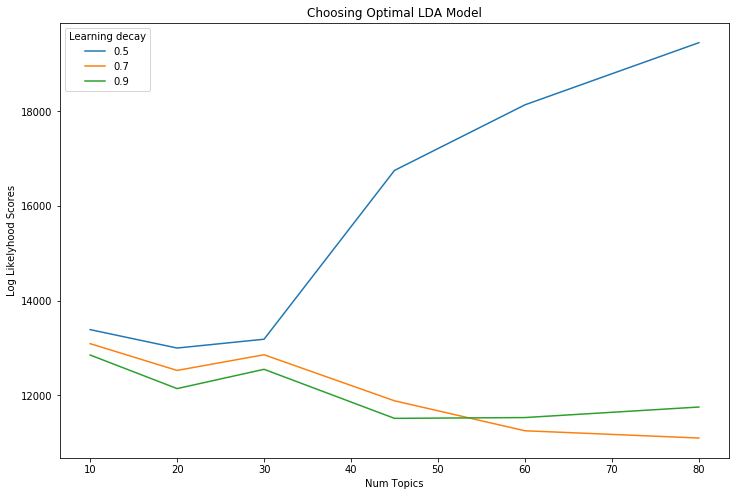

In [0]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 20, 30, 45, 60, 80]
# n_topics = [10, 15, 20, 25, 30]
# log_likelyhoods_5 = [round(gscore.mean_test_score) for gscore in model.cv_results_ if gscore['params']['learning_decay']==0.5]
# log_likelyhoods_7 = [round(gscore.mean_test_score) for gscore in model.cv_results_ if gscore['params']['learning_decay']==0.7]
# log_likelyhoods_9 = [round(gscore.mean_test_score) for gscore in model.cv_results_ if gscore['params']['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

On prend définit un seuil à partir duquel le document appartient à un thème, puis un seuil à partir duquel un mot appartient à un thème. Cela va nous permettre de prédire l'appartenance d'un document à un label.

In [0]:
# seuil_doc = 0.2
# seuil_mot = 0.3

In [0]:
doc_topic_dist

array([[3.54609930e-04, 3.54609930e-04, 3.54609935e-04, ...,
        3.54609930e-04, 5.42736513e-01, 3.54609931e-04],
       [3.97116292e-02, 2.21206108e-01, 4.13223144e-04, ...,
        4.13223147e-04, 4.13223148e-04, 3.74691592e-01],
       [1.02040817e-03, 1.02040820e-03, 4.11819746e-02, ...,
        2.87577095e-02, 1.02040823e-03, 1.02040819e-03],
       ...,
       [1.56250000e-03, 1.56250001e-03, 1.01262368e-01, ...,
        9.41878538e-02, 1.56250001e-03, 5.03948178e-01],
       [7.24637681e-04, 5.22844952e-02, 8.12191184e-02, ...,
        7.24637698e-04, 2.84372219e-02, 7.24637693e-04],
       [5.74712646e-04, 5.74712671e-04, 5.74712653e-04, ...,
        5.74712653e-04, 5.74712650e-04, 5.74712651e-04]])

In [0]:
topic_words_dist

array([[5.00000093e-02, 5.00001231e-02, 5.00036502e-02, ...,
        5.00000280e-02, 5.00000018e-02, 5.10994786e+02],
       [5.00000032e-02, 5.00000008e-02, 6.26900343e+01, ...,
        5.00000172e-02, 5.00000032e-02, 5.00000007e-02],
       [5.00000008e-02, 5.00000006e-02, 3.58539289e+01, ...,
        1.19002287e+01, 5.00000025e-02, 5.00000006e-02],
       ...,
       [5.00000016e-02, 5.00000068e-02, 5.00000922e-02, ...,
        5.00000061e-02, 5.00051051e-02, 5.00002129e-02],
       [5.00000010e-02, 5.00000009e-02, 4.91783426e+01, ...,
        5.00000016e-02, 5.00000055e-02, 5.00012753e-02],
       [5.00000016e-02, 5.00000053e-02, 1.90687721e+01, ...,
        5.00000013e-02, 3.85006494e+02, 5.00000008e-02]])

In [0]:
# On réordonne topic_words pour avoir les même colonnes que y_test (=labels)
seq = y_test.columns

In [0]:
# the dictionary has target_word : replacement_word pairs
wordDict = {
    "c++": "cplusplus",
    'c#': 'csharp',
    '.net': 'dotnet',
    'd3.js': 'd3js',
    'node.js': 'nodejs'
}

In [26]:
for key in wordDict:
  if wordDict[key] in tf_feature_names:
    tf_feature_names[tf_feature_names.index(wordDict[key])] = key
    print("remplacé {} par {}".format(wordDict[key], key))

remplacé cplusplus par c++
remplacé csharp par c#
remplacé dotnet par .net
remplacé nodejs par node.js


In [0]:
df_topic_words = pd.DataFrame(topic_words_dist, columns=tf_feature_names)

In [28]:
df_topic_words = df_topic_words.loc[:, seq]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [0]:
# df_topic_words = df_topic_words.reindex(columns=seq)

In [29]:
df_topic_words.head(5)

,.net,.net-core,amazon-web-services,android,android-gradle,android-studio,angular,angular-cli,apache-spark,arrays,asp.net,asp.net-core,c,c#,c++,c++11,c++17,css,docker,ecmascript-6,firebase,git,google-chrome,gradle,html,intellij-idea,ios,java,java-8,javascript,jquery,json,kotlin,language-lawyer,laravel,macos,node.js,npm,pandas,performance,php,python,python-3.x,r,react-native,reactjs,redux,spring,spring-boot,swift,swift3,tensorflow,typescript,unit-testing,visual-studio,visual-studio-2017,visual-studio-code,vue.js,webpack,xcode,xcode8
0,0.033333,NaN,NaN,0.033334,NaN,NaN,0.033333,NaN,NaN,NaN,NaN,NaN,NaN,115.633905,0.033333,NaN,NaN,NaN,0.033333,NaN,0.033333,0.033333,NaN,0.033333,32.184492,NaN,NaN,0.033333,NaN,0.033594,0.033333,0.033333,0.033333,NaN,0.033333,NaN,0.033377,0.033333,NaN,0.033333,0.033333,0.035867,NaN,NaN,NaN,NaN,0.033333,0.033333,NaN,0.033334,NaN,0.033333,0.033333,NaN,NaN,NaN,NaN,NaN,0.033333,0.033333,NaN
1,0.033335,NaN,NaN,0.033333,NaN,NaN,85.715039,NaN,NaN,NaN,NaN,NaN,NaN,0.033333,0.033333,NaN,NaN,NaN,0.033333,NaN,0.033333,0.033333,NaN,0.033333,104.409589,NaN,NaN,0.033333,NaN,0.033333,0.033333,3.794433,0.033333,NaN,452.052937,NaN,0.033337,0.033333,NaN,0.033333,0.033335,0.033333,NaN,NaN,NaN,NaN,0.033333,0.033333,NaN,0.033333,NaN,0.033333,0.033333,NaN,NaN,NaN,NaN,NaN,0.033343,0.033333,NaN
2,0.033333,NaN,NaN,0.033333,NaN,NaN,0.033333,NaN,NaN,NaN,NaN,NaN,NaN,0.033333,0.033333,NaN,NaN,NaN,0.033333,NaN,0.033333,0.033333,NaN,0.033333,89.174854,NaN,NaN,0.033333,NaN,201.043795,0.033333,0.103803,0.033333,NaN,0.033342,NaN,0.033338,0.033333,NaN,128.302820,0.033334,0.033333,NaN,NaN,NaN,NaN,0.033333,0.033333,NaN,0.033334,NaN,0.033333,0.033333,NaN,NaN,NaN,NaN,NaN,0.033334,0.033333,NaN
3,0.033333,NaN,NaN,0.033333,NaN,NaN,0.033333,NaN,NaN,NaN,NaN,NaN,NaN,0.033333,0.033333,NaN,NaN,NaN,2218.622393,NaN,0.033333,0.033333,NaN,0.033333,0.033333,NaN,NaN,0.033333,NaN,0.033333,0.033333,140.019404,0.033333,NaN,0.033333,NaN,439.932521,2442.415517,NaN,0.033333,0.033333,0.033333,NaN,NaN,NaN,NaN,0.033333,0.033333,NaN,0.033333,NaN,0.033333,0.033333,NaN,NaN,NaN,NaN,NaN,0.033370,0.033333,NaN
4,0.033333,NaN,NaN,9724.087775,NaN,NaN,0.033333,NaN,NaN,NaN,NaN,NaN,NaN,0.033333,0.033333,NaN,NaN,NaN,0.033333,NaN,0.033333,0.033333,NaN,0.033344,0.033333,NaN,NaN,0.033333,NaN,0.033333,0.033333,0.033333,0.033335,NaN,0.033333,NaN,0.033333,0.033333,NaN,0.033333,0.033333,0.033333,NaN,NaN,NaN,NaN,0.033333,0.033333,NaN,0.033333,NaN,0.033333,0.033333,NaN,NaN,NaN,NaN,NaN,0.033333,0.033333,NaN


In [0]:
y_test.reset_index(drop=True, inplace=True)

In [0]:
# On initialise un dictionnaire dans lequel on va stocker les performances pour comparaison
res_lda = {'Seuil doc': [], 'Seuil word': [], 'Score': []}

seuils_d = [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
            0.1, 0.11, 0.12, 0.13, .14, 0.15,
            0.2, 0.3, 0.4]
seuils_w = [0.001, 1, 5, 10, 25, 50, 75, 100, 200, 300, 350, 400, 450, 475, 500, 525, 550,
            600, 650, 700, 750, 800, 850, 900, 950, 1000, 
            1100, 1200, 1300, 1400, 1500, 2000, 2500, 3000, 3500, 4000]

for seuil_word  in seuils_w:
  topic_word = (df_topic_words > seuil_word).astype(int)
  for seuil_doc in seuils_d:
    doc_topic = (doc_topic_dist > seuil_doc).astype(int)
  
    
    # Correspondance document - Mot clé
    doc_word_matrix = np.dot(doc_topic, topic_word).astype(bool)
    doc_word_df = pd.DataFrame(doc_word_matrix, columns=seq)
    
    lda_score = jaccard_score(y_test, doc_word_df, average='samples')
    
    # On ajoute le score
    res_lda['Seuil doc'].append(seuil_doc)
    res_lda['Seuil word'].append(seuil_word)
    res_lda['Score'].append(lda_score)
    
# print(pd.DataFrame.from_dict(res_lda))

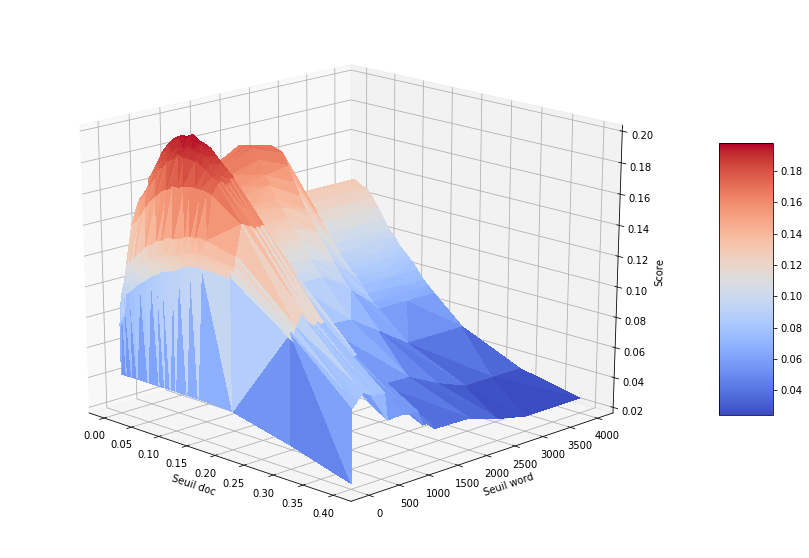

In [32]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')

# Make data.
X = np.array(res_lda['Seuil doc'])
Y = np.array(res_lda['Seuil word'])
# X, Y = np.meshgrid(X, Y)
Z = np.array(res_lda['Score'])
# Z = np.array([res_lda['Score'],res_lda['Score']])

# Plot the surface.
# surf = ax.plot_surface(X, Y, Z)
surf = ax.plot_trisurf(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(0, 0.5)
ax.view_init(elev=20., azim=315)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set_xlabel('Seuil doc')
ax.set_ylabel('Seuil word')
ax.set_zlabel('Score')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [34]:
pd.DataFrame(res_lda).describe()

,Seuil doc,Seuil word,Score
count,720.000000,720.000000,720.000000
mean,0.105300,908.777806,0.131485
std,0.098115,971.299553,0.041294
min,0.001000,0.001000,0.015281
25%,0.037500,275.000000,0.104965
50%,0.085000,625.000000,0.139733
75%,0.132500,1125.000000,0.161626
max,0.400000,4000.000000,0.198412


In [0]:
import numpy as np

In [0]:
# Get the indices of maximum element in numpy array
idx = np.array(np.where(res_lda['Score'] == np.amax(res_lda['Score'])))

In [63]:
for index in idx[0]:
  print("Index: {}   Seuil doc: {}   Seuil word: {}".format(index, res_lda['Seuil doc'][index], res_lda['Seuil word'][index]))

Index: 289   Seuil doc: 0.08   Seuil word: 500
Index: 309   Seuil doc: 0.08   Seuil word: 525
Index: 329   Seuil doc: 0.08   Seuil word: 550


In [64]:
seuil_word = 500
seuil_doc = 0.08

topic_word = (df_topic_words > seuil_word).astype(int)
doc_topic = (doc_topic_dist > seuil_doc).astype(int)
doc_word_matrix = np.dot(doc_topic, topic_word).astype(bool)
doc_word_df = pd.DataFrame(doc_word_matrix, columns=seq)
    
print(jaccard_score(y_test, doc_word_df, average='samples'))

0.19841237797541522


In [72]:
doc_word_df

,.net,.net-core,amazon-web-services,android,android-gradle,android-studio,angular,angular-cli,apache-spark,arrays,asp.net,asp.net-core,c,c#,c++,c++11,c++17,css,docker,ecmascript-6,firebase,git,google-chrome,gradle,html,intellij-idea,ios,java,java-8,javascript,jquery,json,kotlin,language-lawyer,laravel,macos,node.js,npm,pandas,performance,php,python,python-3.x,r,react-native,reactjs,redux,spring,spring-boot,swift,swift3,tensorflow,typescript,unit-testing,visual-studio,visual-studio-2017,visual-studio-code,vue.js,webpack,xcode,xcode8
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,

In [0]:
!pip install pyldavis

     |████████████████████████████████| 1.6MB 6.3MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=4c71dc3876ae3ee197d80673e52aecc788406c6a1e31748021b2e4a2a6ebf73a
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyldavis


In [0]:
import pyLDAvis
pyLDAvis.enable_notebook()

In [0]:
import gensim

/usr/local/lib/python3.6/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [0]:
from gensim import corpora, models

# dictionary = corpora.Dictionary(X_train_count)

In [0]:
# dictionary

In [0]:
np.shape(topic_words_dist)

(30, 1000)

In [0]:
vect_data = np.array(vectorizer.transform(X_test))

In [0]:
vect_data

array(<3490x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 119337 stored elements in Compressed Sparse Row format>,
      dtype=object)

In [0]:
np.shape(doc_topic_dist)

(3490, 30)

In [0]:
np.shape(doc_len)

(3490,)

In [0]:
pyLDAvis.prepare(topic_term_dists = topic_words_dist,
                 doc_topic_dists = doc_topic_dist,
                 doc_lengths = doc_len,
                 vocab = tf_feature_names,
                 term_frequency = dist_terms,
                 R=30,
                 lambda_step=0.01,
                 mds= 'tsne',    #js_PCoA,
                 n_jobs=-1,
                 plot_opts={'xlab': 'PC1', 'ylab': 'PC2'},
                 sort_topics=True)

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2      52.034561   5.946712       1        1  15.130412
25     16.276966  63.834599       2        1   6.197699
0      55.756340 -26.179474       3        1   5.588473
9     -24.823668 -38.022125       4        1   5.213938
24      1.945029   3.046064       5        1   4.743571
18     81.472778  -6.399980       6        1   3.690354
16     21.588268 -75.646568       7        1   3.539050
27     37.859241  38.269089       8        1   3.532665
29    -75.403374 -36.492542       9        1   3.485664
20      6.881996  34.004578      10        1   3.222432
19    -46.947433  66.998520      11        1   3.197367
4     -41.820030  36.449627      12        1   3.173440
10    -47.894730 -58.465439      13        1   2.757187
11    -18.727785 -77.096756      14        1   2.697838
12    -46.732635   8.225553      15        1   2.693381
1     -22.787912  -8.617471      16        1   2.667989
3     -77.106262  -0.604798      17        1   2.636912
7      55.461514 -58.207344      18        1   2.605852
15    -72.901039  34.046303      19        1   2.430616
14     -0.184662 -52.428074      20        1   2.314326
8      27.716246 -13.575693      21        1   2.301687
28     25.494383  13.780796      22        1   2.271675
13    -11.031527  82.168755      23        1   2.224034
21     70.444191  32.392784      24        1   2.180148
6      49.649811  67.150002      25        1   2.100601
22      1.504659 -24.028341      26        1   1.883750
5     -48.695404 -21.197170      27        1   1.791043
23    -18.574261  20.098297      28        1   1.454599
17     27.286421 -41.878319      29        1   1.196628
26    -15.606266  50.876411      30        1   1.076666, topic_info=    Category          Freq         Term         Total  loglift  logprob
30   Default  1.709795e+08      android  1.709795e+08  30.0000  30.0000
448  Default  1.519862e+08         java  1.519862e+08  29.0000  29.0000
490  Default  1.978794e+08         like  1.978794e+08  28.0000  28.0000
159  Default  1.118093e+08          com  1.118093e+08  27.0000  27.0000
982  Default  1.277092e+08        would  1.277092e+08  26.0000  26.0000
963  Default  1.353166e+08          way  1.353166e+08  25.0000  25.0000
831  Default  7.081984e+07       string  7.081984e+07  24.0000  24.0000
43   Default  7.072088e+07          app  7.072088e+07  23.0000  23.0000
144  Default  9.179122e+07        class  9.179122e+07  22.0000  22.0000
681  Default  5.668879e+07       public  5.668879e+07  21.0000  21.0000
169  Default  4.482677e+07    component  4.482677e+07  20.0000  20.0000
927  Default  1.801256e+08          use  1.801256e+08  19.0000  19.0000
335  Default  8.594787e+07         file  8.594787e+07  18.0000  18.0000
253  Default  5.198147e+07          div  5.198147e+07  17.0000  17.0000
690  Default  8.622621e+07     question  8.622621e+07  16.0000  16.0000
364  Default  4.490178e+07     function  4.490178e+07  15.0000  15.0000
599  Default  1.155094e+08          one  1.155094e+08  14.0000  14.0000
434  Default  4.656827e+07          int  4.656827e+07  13.0000  13.0000
931  Default  1.968960e+08        using  1.968960e+08  12.0000  12.0000
942  Default  4.260208e+07        value  4.260208e+07  11.0000  11.0000
611  Default  4.666720e+07      package  4.666720e+07  10.0000  10.0000
31   Default  4.161296e+07      angular  4.161296e+07   9.0000   9.0000
380  Default  4.714326e+07       google  4.714326e+07   8.0000   8.0000
569  Default  8.810369e+07         need  8.810369e+07   7.0000   7.0000
406  Default  3.637529e+07         http  3.637529e+07   6.0000   6.0000
416  Default  4.074392e+07       import  4.074392e+07   5.0000   5.0000
562  Default  4.034506e+07         name  4.034506e+07   4.0000   4.0000
216  Default  8.059347e+07         data  8.059347e+07   3.0000   3.0000
573  Default  1.097714e+08          new  1.097714e+08   2.0000   2.0000
904  

## Sauvegarde du modele sélectionné

In [0]:
data_filename_memmap = os.path.join(folder, 'tfidf_memmap')
dump(tfidf_transformer, data_filename_memmap)

In [0]:
data_filename_memmap = os.path.join(folder, 'svc_memmap')
dump(gs_svc, data_filename_memmap)

In [0]:
data_filename_memmap = os.path.join(folder, 'labels_memmap')
dump(y_test.columns, data_filename_memmap)